In [1]:
library(modelr)
library(tidyverse)
library(lubridate)
theme_set(theme_minimal())

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.7
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



# Lecture 19: Building models for `gapminder`
The `gapminder` package contains data from [Gapminder](https://www.gapminder.org/), which was popularised by Swedish statistician Hans Rosling. If you don't know about this data or this person, take five minutes and [watch one of his videos](https://www.youtube.com/watch?v=jbkSRLYSojo) before coming to lecture.

In [2]:
library(gapminder)
gapminder %>% print

# A tibble: 1,704 x 6
   country     continent  year lifeExp      pop gdpPercap
   <fct>       <fct>     <int>   <dbl>    <int>     <dbl>
 1 Afghanistan Asia       1952    28.8  8425333      779.
 2 Afghanistan Asia       1957    30.3  9240934      821.
 3 Afghanistan Asia       1962    32.0 10267083      853.
 4 Afghanistan Asia       1967    34.0 11537966      836.
 5 Afghanistan Asia       1972    36.1 13079460      740.
 6 Afghanistan Asia       1977    38.4 14880372      786.
 7 Afghanistan Asia       1982    39.9 12881816      978.
 8 Afghanistan Asia       1987    40.8 13867957      852.
 9 Afghanistan Asia       1992    41.7 16317921      649.
10 Afghanistan Asia       1997    41.8 22227415      635.
# ... with 1,694 more rows


To begin with we will focus on how life expectancy varies by year and by country.

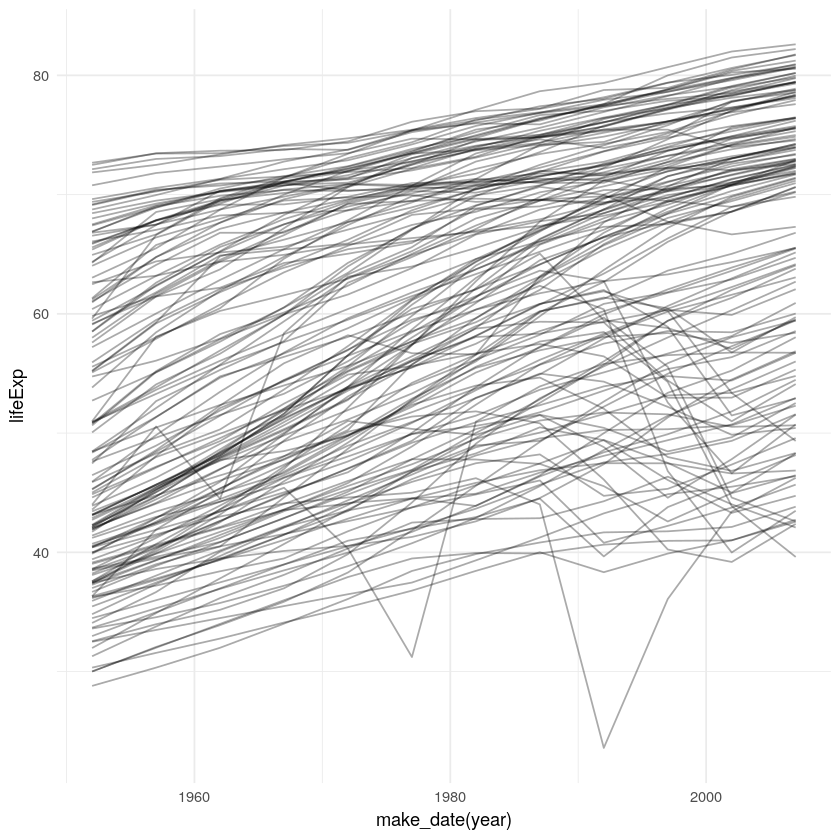

In [3]:
ggplot(gapminder, aes(x = make_date(year), y = lifeExp, group = country)) + 
    geom_line(alpha = 1/3) # add regression line

The regression line shows that overall trend in life expectancy has been upwards over the last fifty years. That's good! But there are some obvious exceptions. To cast those into sharper relief, let's subtract the linear trend from each series.

The linear trend is a good fit most of the non-African and non-Asian countries. However, beginning in the 1990s, a number of African countries have lagged far behind the rest of the world in terms of life expectancy. This is reflected in the negative residuals show in blue on the lower-right portion of this graph.

## Nested models
To dig deeper we will fit a separate linear model to each country. We'll first define a model function:

In [4]:
country_model <- function(df) {
  lm(lifeExp ~ year, data = df)
}

We want to fit this model to each country in our data frame. One option would be to use a for loop:

In [5]:
countries = unique(gapminder$country)
by_country = vector("list", length(countries))
for (i in seq_along(by_country)) {
    df = filter(gapminder, country == countries[[i]])
    by_country[[i]] = country_model(df)
}

As you might have guessed by now, we prefer to avoid this style of coding where possible. What we would like to be able to do is `map()` the `country_model()` function over a list of data frames, one per country. In order to do this we need a way to convert `gapminder` into series of data frames, one per country.

This is the purpose of the `nest()` command:

In [6]:
by_country = gapminder %>% group_by(country, continent) %>% nest %>% print

# A tibble: 142 x 3
   country     continent data             
   <fctr>      <fctr>    <list>           
 1 Afghanistan Asia      <tibble [12 × 4]>
 2 Albania     Europe    <tibble [12 × 4]>
 3 Algeria     Africa    <tibble [12 × 4]>
 4 Angola      Africa    <tibble [12 × 4]>
 5 Argentina   Americas  <tibble [12 × 4]>
 6 Australia   Oceania   <tibble [12 × 4]>
 7 Austria     Europe    <tibble [12 × 4]>
 8 Bahrain     Asia      <tibble [12 × 4]>
 9 Bangladesh  Asia      <tibble [12 × 4]>
10 Belgium     Europe    <tibble [12 × 4]>
# ... with 132 more rows


The `nest()` command has created a new `data` column. This column contains a copy of `gapminder`, filtered to contain only the rows that match the grouping variables. Thus:

In [7]:
by_country[1,] %>% print
by_country[[1, 3]] %>% print

# A tibble: 1 x 3
  country     continent data             
  <fctr>      <fctr>    <list>           
1 Afghanistan Asia      <tibble [12 × 4]>
# A tibble: 12 x 4
    year lifeExp      pop gdpPercap
   <int>   <dbl>    <int>     <dbl>
 1  1952    28.8  8425333       779
 2  1957    30.3  9240934       821
 3  1962    32.0 10267083       853
 4  1967    34.0 11537966       836
 5  1972    36.1 13079460       740
 6  1977    38.4 14880372       786
 7  1982    39.9 12881816       978
 8  1987    40.8 13867957       852
 9  1992    41.7 16317921       649
10  1997    41.8 22227415       635
11  2002    42.1 25268405       727
12  2007    43.8 31889923       975


Each of these rows is for Afghanistan, as can verify:

In [8]:
gapminder %>% filter(country == "Afghanistan")

   country     continent year lifeExp pop      gdpPercap
1  Afghanistan Asia      1952 28.801   8425333 779.4453 
2  Afghanistan Asia      1957 30.332   9240934 820.8530 
3  Afghanistan Asia      1962 31.997  10267083 853.1007 
4  Afghanistan Asia      1967 34.020  11537966 836.1971 
5  Afghanistan Asia      1972 36.088  13079460 739.9811 
6  Afghanistan Asia      1977 38.438  14880372 786.1134 
7  Afghanistan Asia      1982 39.854  12881816 978.0114 
8  Afghanistan Asia      1987 40.822  13867957 852.3959 
9  Afghanistan Asia      1992 41.674  16317921 649.3414 
10 Afghanistan Asia      1997 41.763  22227415 635.3414 
11 Afghanistan Asia      2002 42.129  25268405 726.7341 
12 Afghanistan Asia      2007 43.828  31889923 974.5803 

This is another example of a `list-column`, where we store R objects (which are lists plus additional attributes) inside of a data frame or tibble.

The nested data frame makes it easy to fit one model per country:

In [9]:
models = by_country$data %>% map(country_model)
models[[1]]


Call:
lm(formula = lifeExp ~ year, data = df)

Coefficients:
(Intercept)         year  
  -507.5343       0.2753  


However, it makes more sense to store the models inside of the `gap_n` table rather than leave them floating about.

In [10]:
by_country = by_country %>% mutate(model = map(data, country_model)) %>% print

# A tibble: 142 x 4
   country     continent data              model   
   <fctr>      <fctr>    <list>            <list>  
 1 Afghanistan Asia      <tibble [12 × 4]> <S3: lm>
 2 Albania     Europe    <tibble [12 × 4]> <S3: lm>
 3 Algeria     Africa    <tibble [12 × 4]> <S3: lm>
 4 Angola      Africa    <tibble [12 × 4]> <S3: lm>
 5 Argentina   Americas  <tibble [12 × 4]> <S3: lm>
 6 Australia   Oceania   <tibble [12 × 4]> <S3: lm>
 7 Austria     Europe    <tibble [12 × 4]> <S3: lm>
 8 Bahrain     Asia      <tibble [12 × 4]> <S3: lm>
 9 Bangladesh  Asia      <tibble [12 × 4]> <S3: lm>
10 Belgium     Europe    <tibble [12 × 4]> <S3: lm>
# ... with 132 more rows


By keeping the model, data frame, and country/continent all together, everything stays in sync when we alter the data in some way:

In [11]:
by_country %>% arrange(continent, country) %>% print

# A tibble: 142 x 4
   country                  continent data              model   
   <fctr>                   <fctr>    <list>            <list>  
 1 Algeria                  Africa    <tibble [12 × 4]> <S3: lm>
 2 Angola                   Africa    <tibble [12 × 4]> <S3: lm>
 3 Benin                    Africa    <tibble [12 × 4]> <S3: lm>
 4 Botswana                 Africa    <tibble [12 × 4]> <S3: lm>
 5 Burkina Faso             Africa    <tibble [12 × 4]> <S3: lm>
 6 Burundi                  Africa    <tibble [12 × 4]> <S3: lm>
 7 Cameroon                 Africa    <tibble [12 × 4]> <S3: lm>
 8 Central African Republic Africa    <tibble [12 × 4]> <S3: lm>
 9 Chad                     Africa    <tibble [12 × 4]> <S3: lm>
10 Comoros                  Africa    <tibble [12 × 4]> <S3: lm>
# ... with 132 more rows


Now we can add in the residuals that we sought to compute earlier:

In [12]:
by_country = mutate(by_country, resids = map2(data, model, add_residuals)) %>% print

# A tibble: 142 x 5
   country     continent data              model    resids           
   <fctr>      <fctr>    <list>            <list>   <list>           
 1 Afghanistan Asia      <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
 2 Albania     Europe    <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
 3 Algeria     Africa    <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
 4 Angola      Africa    <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
 5 Argentina   Americas  <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
 6 Australia   Oceania   <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
 7 Austria     Europe    <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
 8 Bahrain     Asia      <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
 9 Bangladesh  Asia      <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
10 Belgium     Europe    <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
# ... with 132 more rows


The inverse operation to `nest()` is `unnest()`. This takes a set of nested data frames and expands them back into a single, unnested dataframe:

In [13]:
resids = by_country %>% unnest(resids) %>% print

# A tibble: 1,704 x 7
   country     continent  year lifeExp      pop gdpPercap   resid
   <fctr>      <fctr>    <int>   <dbl>    <int>     <dbl>   <dbl>
 1 Afghanistan Asia       1952    28.8  8425333       779 -1.11  
 2 Afghanistan Asia       1957    30.3  9240934       821 -0.952 
 3 Afghanistan Asia       1962    32.0 10267083       853 -0.664 
 4 Afghanistan Asia       1967    34.0 11537966       836 -0.0172
 5 Afghanistan Asia       1972    36.1 13079460       740  0.674 
 6 Afghanistan Asia       1977    38.4 14880372       786  1.65  
 7 Afghanistan Asia       1982    39.9 12881816       978  1.69  
 8 Afghanistan Asia       1987    40.8 13867957       852  1.28  
 9 Afghanistan Asia       1992    41.7 16317921       649  0.754 
10 Afghanistan Asia       1997    41.8 22227415       635 -0.534 
# ... with 1,694 more rows


Now we can plot the residuals by country, as originally intended:

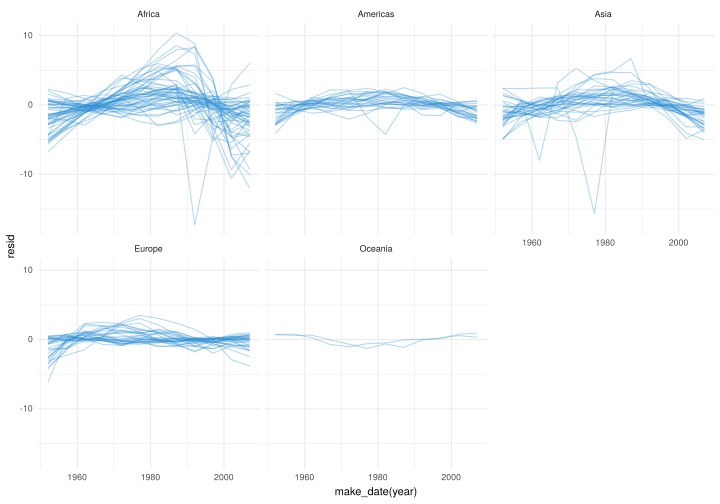

In [14]:
ggplot(resids, aes(x = make_date(year), y = resid, group = country)) + 
    geom_line(alpha = 1/3) + facet_wrap(~ continent)

Note that this is a roundabout way of getting the residuals by country. We could have just as easily fit a linear model with different slope and intercept terms for each country to get the same plot:

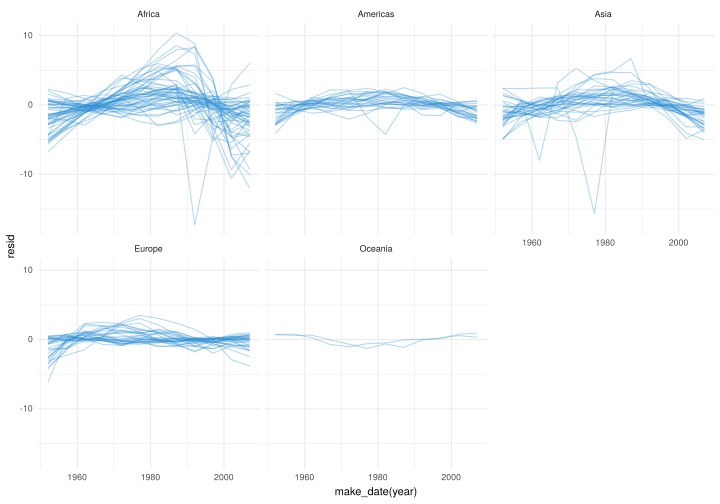

In [15]:
model = lm(lifeExp ~ year * country, gapminder)
gapminder %>% add_residuals(model) %>% ggplot(aes(x = make_date(year), y = resid, group = country)) + 
    geom_line(alpha = 1/3) + facet_wrap(~ continent) # add regression line

However, fitting a separate model for each country allows us to make other measurements of model quality, as we shall now see.

## Other measurements of model quality
So far we have looked at residuals to judge how well the models fit. There are other more general measurements of model quality. To help us look at these we will use the `broom` package for turning models into tidy data:

In [16]:
library(broom)


Attaching package: ‘broom’

The following object is masked from ‘package:modelr’:

    bootstrap



The `broom::glance()` function lets us quickly look at a model and judge how well it fits:

In [17]:
nz = gapminder %>% filter(country == "New Zealand")
nz_mod = lm(lifeExp ~ year, data = nz)
glance(nz_mod)

  r.squared adj.r.squared sigma     statistic p.value      df logLik   
1 0.9535846 0.9489431     0.8043472 205.4459  5.407324e-08 2  -13.32064
  AIC      BIC    deviance df.residual
1 32.64128 34.096 6.469743 10         

`glance` prints out some technical measurements of how well the model fits. The basic one is `r.squared`. In the simple linear model this simply measures the square of the correlation between the predictions $\hat{\mathbf{y}}$ and the observations $\mathbf{y}$:

In [18]:
nz %>% add_predictions(nz_mod) %>% summarize(r2 = cor(lifeExp, pred) ** 2)

  r2       
1 0.9535846

Using the commands we have learned so far, we can apply the glance function to each model in `by_country` in order to extract the $R^2$:

In [19]:
gl = by_country %>% mutate(glance = map(model, glance)) %>% 
                    unnest(glance, .drop = T) %>% print

# A tibble: 142 x 13
   country conti… r.squ… adj.r… sigma stati…   p.value    df logLik   AIC   BIC
   <fctr>  <fctr>  <dbl>  <dbl> <dbl>  <dbl>     <dbl> <int>  <dbl> <dbl> <dbl>
 1 Afghan… Asia    0.948  0.942 1.22   181    9.84e⁻ ⁸     2 -18.3  42.7  44.1 
 2 Albania Europe  0.911  0.902 1.98   102    1.46e⁻ ⁶     2 -24.1  54.3  55.8 
 3 Algeria Africa  0.985  0.984 1.32   662    1.81e⁻¹⁰     2 -19.3  44.6  46.0 
 4 Angola  Africa  0.888  0.877 1.41    79.1  4.59e⁻ ⁶     2 -20.0  46.1  47.5 
 5 Argent… Ameri…  0.996  0.995 0.292 2246    4.22e⁻¹³     2 - 1.17  8.35  9.80
 6 Austra… Ocean…  0.980  0.978 0.621  481    8.67e⁻¹⁰     2 -10.2  26.4  27.9 
 7 Austria Europe  0.992  0.991 0.407 1261    7.44e⁻¹²     2 - 5.16 16.3  17.8 
 8 Bahrain Asia    0.967  0.963 1.64   291    1.02e⁻ ⁸     2 -21.9  49.7  51.2 
 9 Bangla… Asia    0.989  0.988 0.977  930    3.37e⁻¹¹     2 -15.7  37.3  38.8 
10 Belgium Europe  0.995  0.994 0.293 1822    1.20e⁻¹²     2 - 1.20  8.40  9.85
# ... with 132 more

Plotting the resulting data, we see that most countries are fit pretty well by the linear model. But some countries, especially those in Africa, have a very bad fit:

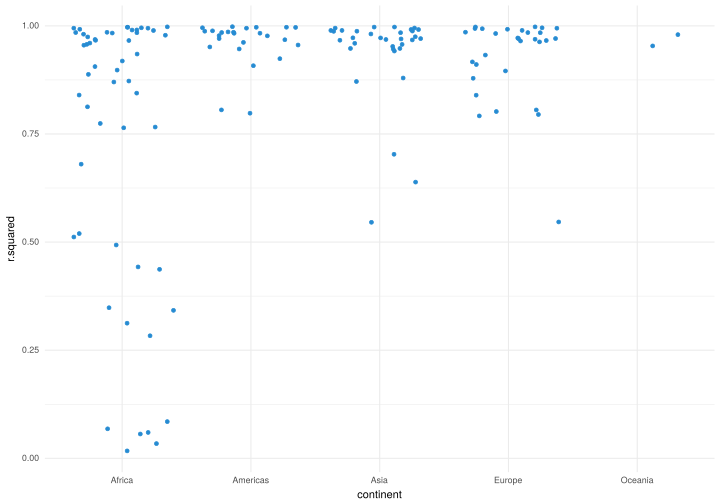

In [20]:
ggplot(gl, aes(x = continent, y = r.squared)) + geom_jitter()

Let's extract those for further analysis:

Joining, by = c("country", "continent")


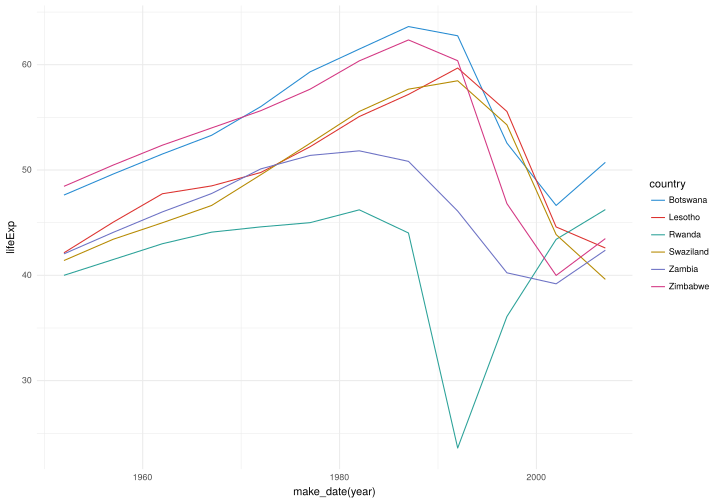

In [21]:
bad_fit = filter(gl, r.squared < 0.25)
gapminder %>% semi_join(bad_fit) %>% 
    ggplot(aes(make_date(year), lifeExp, color = country)) +
    geom_line()

There was a strong upward trend in life expectancy for 1950 to 1980 in these countries. Tragically, it was cut short in the 1990s. There are two reasons for this: the HIV/AIDS epidemic, and the Rwandan genocide.

This graph is really powerful. We can use the data to help us imagine what life would be like in these countries if not for these events:

In [22]:
afr = gapminder %>% semi_join(bad_fit) %>% group_by(country) %>% nest %>% 
      mutate(model = map(data, function(df) lm(lifeExp ~ year, df, subset = year < 1980)),
             pred_data = map2(data, model, function(df, m) add_predictions(df, m))) %>% 
      unnest(pred_data) %>% gather(prediction_type, lifeExp, lifeExp, pred) 

Joining, by = c("country", "continent")


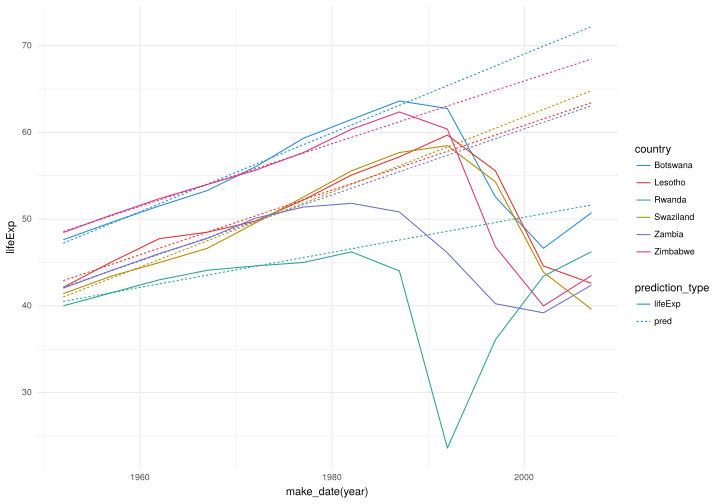

In [23]:
afr %>% ggplot(aes(x = make_date(year), y = lifeExp, color = country)) +
        geom_line(aes(linetype = prediction_type))

We predict that Botswana would now have had a life expectancy of about 75 years, on par with other developed countries.

## Drops in life expectancy
The preceding graph motivates the question: which countries experienced the sharpest five-year drops in life expectancy? Can we explain why these occurred?

In [183]:
dlife = gapminder %>% arrange(country, year) %>% group_by(country) %>% 
                      mutate(dlife = c(NA, diff(lifeExp))) %>% arrange(dlife) %>% 
                      mutate(cy = str_c(country, ", ", year)) %>% ungroup
mdlife = mean(dlife$dlife, na.rm = T)

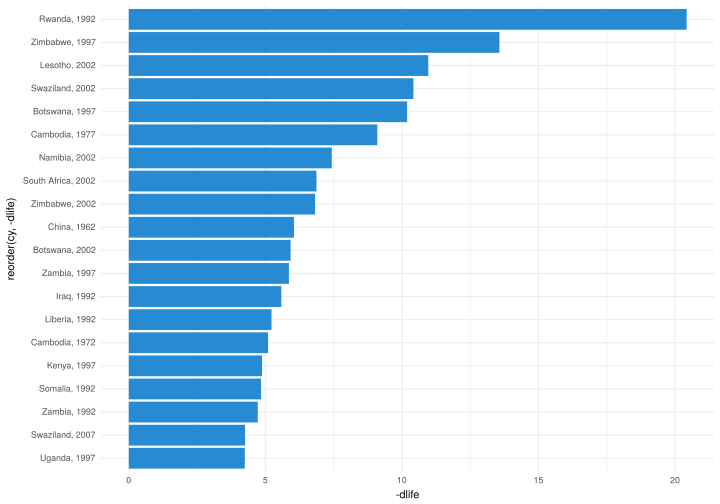

In [187]:
dlife %>% top_n(20, -dlife) %>% ggplot(aes(x = reorder(cy, -dlife), y = -dlife)) + geom_col() + coord_flip()

In most cases these drops in life expectancy appear to be due to the HIV/AIDS epidemic that ravaged sub-Saharan Africa in the late 1990s. To investigate this phenomenon further we will look at an [additional Gapminder data source](https://www.gapminder.org/data/) on the HIV infection rates.

## Reading Microsoft Excel files
The particular data we are interested in come are distributed as a Microsoft Excel spreadsheet. A lot of socio-economic data are distributed in this way, so this gives us a good chance to practice importing Excel data into R. 

<small>(This is probably the only time I will ever say something to the effect of "luckily, the data are in Excel format".)</small>

`tidyverse` conveniently gives us a `readxl` library for importing Excel data into R:

In [197]:
library(readxl)
hiv = readxl::read_xlsx("indicator hiv estimated prevalence% 15-49.xlsx") %>% print

# A tibble: 275 x 34
   `Estim… `1979.0` `198… `198… `198… `198… `198… `198… `198… `198… `198… `198…
   <chr>      <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <lgl> <lgl>
 1 Abkhaz…  NA         NA    NA    NA    NA    NA    NA    NA    NA NA    NA   
 2 Afghan…  NA         NA    NA    NA    NA    NA    NA    NA    NA NA    NA   
 3 Akroti…  NA         NA    NA    NA    NA    NA    NA    NA    NA NA    NA   
 4 Albania  NA         NA    NA    NA    NA    NA    NA    NA    NA NA    NA   
 5 Algeria  NA         NA    NA    NA    NA    NA    NA    NA    NA NA    NA   
 6 Americ…  NA         NA    NA    NA    NA    NA    NA    NA    NA NA    NA   
 7 Andorra  NA         NA    NA    NA    NA    NA    NA    NA    NA NA    NA   
 8 Angola    0.0265    NA    NA    NA    NA    NA    NA    NA    NA NA    NA   
 9 Anguil…  NA         NA    NA    NA    NA    NA    NA    NA    NA NA    NA   
10 Antigu…  NA         NA    NA    NA    NA    NA    NA    NA    NA NA    NA   
# ... with 265 more

These data are untidy. We will `gather` them into a tidy format suitable for analysis:

In [198]:
hiv = gather(hiv, year, hiv_pct, -1) %>% mutate(year = make_date(str_sub(year, 1, 4)),
                                                hiv_pct = as.numeric(hiv_pct))
names(hiv)[[1]] = "country"
print(hiv)

# A tibble: 9,075 x 3
   country               year       hiv_pct
   <chr>                 <date>       <dbl>
 1 Abkhazia              1979-01-01 NA     
 2 Afghanistan           1979-01-01 NA     
 3 Akrotiri and Dhekelia 1979-01-01 NA     
 4 Albania               1979-01-01 NA     
 5 Algeria               1979-01-01 NA     
 6 American Samoa        1979-01-01 NA     
 7 Andorra               1979-01-01 NA     
 8 Angola                1979-01-01  0.0265
 9 Anguilla              1979-01-01 NA     
10 Antigua and Barbuda   1979-01-01 NA     
# ... with 9,065 more rows


Warning message:
“Removed 176 rows containing missing values (geom_path).”

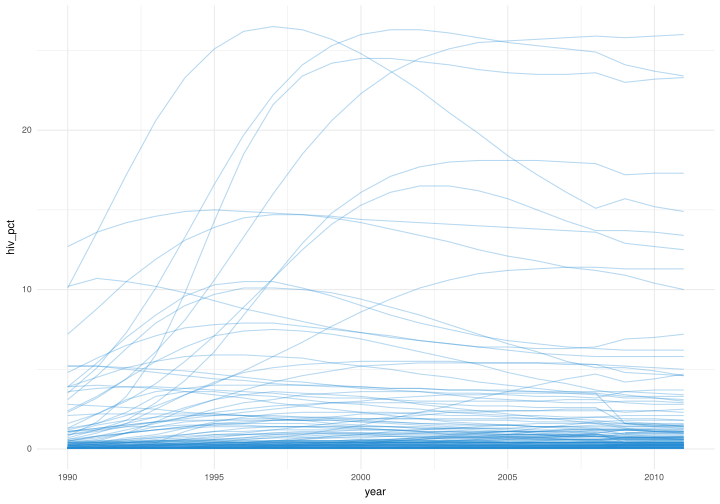

In [199]:
hiv %>% filter(year >= make_date(1990)) %>% 
    ggplot(aes(year, hiv_pct, group = country)) + geom_line(alpha = 1/3)

To gain further insight, we can join the HIV data to our other gapminder data:

Joining, by = "country"
Warning message:
“Column `country` joining character vector and factor, coercing into character vector”Warning message:
“Removed 103 rows containing missing values (geom_path).”

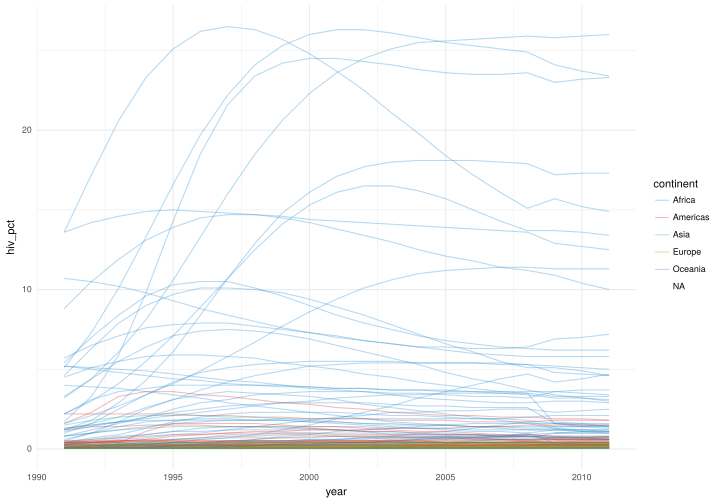

In [200]:
gapminder %>% distinct(country, continent) %>% left_join(hiv, .) %>% 
    filter(year > make_date(1990)) %>% 
    ggplot(aes(year, hiv_pct, group = country, colour = continent)) + geom_line(alpha = 1 / 3)

Let us study further the relationship between HIV rate and life expectancy.

Joining, by = c("country", "year")
Warning message:
“Column `country` joining factor and character vector, coercing into character vector”Warning message:
“Removed 1222 rows containing missing values (geom_point).”

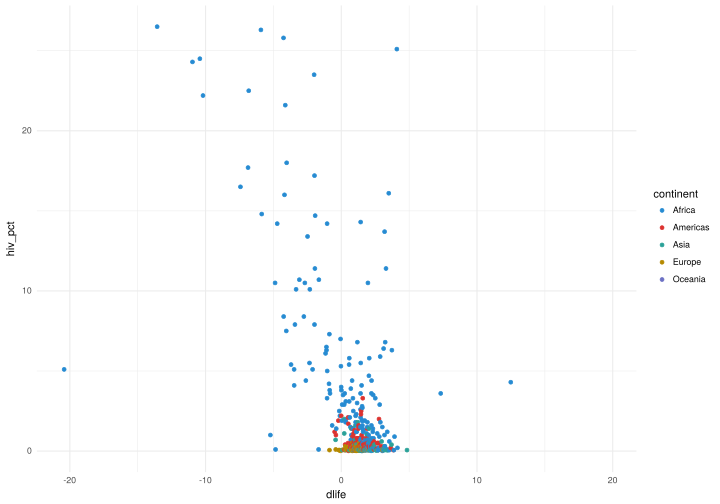

In [201]:
hiv_dlife = dlife %>% ungroup %>% mutate(year = make_date(year), dlife) %>%
    left_join(hiv)
ggplot(hiv_dlife, aes(dlife, hiv_pct)) + geom_point(aes(color = continent))

The data indicate a negative association between HIV and life expectancy. One subtle issue is that there might be a lag between the rate of HIV infection and life expectancy. It might be smarter to compare the change in life expectancy to the rate of HIV infection from some years prior:

Warning message:
“Removed 1223 rows containing missing values (geom_point).”

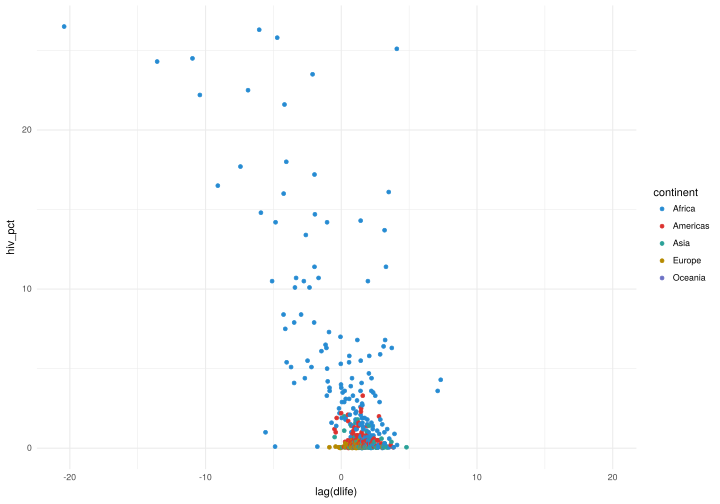

In [202]:
ggplot(hiv_dlife, aes(lag(dlife), hiv_pct)) + geom_point(aes(color = continent))

Let us try and quantify this relationship using a linear model:

In [203]:
hiv_gap = gapminder %>% mutate(year = make_date(year)) %>% left_join(hiv)
mod = lm(lifeExp ~ hiv_pct, hiv_gap)
mod %>% summary

Joining, by = c("country", "year")
Warning message:
“Column `country` joining factor and character vector, coercing into character vector”


Call:
lm(formula = lifeExp ~ hiv_pct, data = hiv_gap)

Residuals:
    Min      1Q  Median      3Q     Max 
-36.932  -7.472   2.710   8.158  18.676 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  67.7930     0.5112  132.61   <2e-16 ***
hiv_pct      -1.4239     0.1036  -13.75   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.2 on 480 degrees of freedom
  (1222 observations deleted due to missingness)
Multiple R-squared:  0.2825,	Adjusted R-squared:  0.281 
F-statistic:   189 on 1 and 480 DF,  p-value: < 2.2e-16


This says that a 1% increase in the HIV infection percentage leads to a decreased life expectancy of -1.4 years, on average. However, there is a potential problem with this regression fit. To see it, let's look at residuals:

Warning message:
“Removed 1348 rows containing missing values (geom_point).”

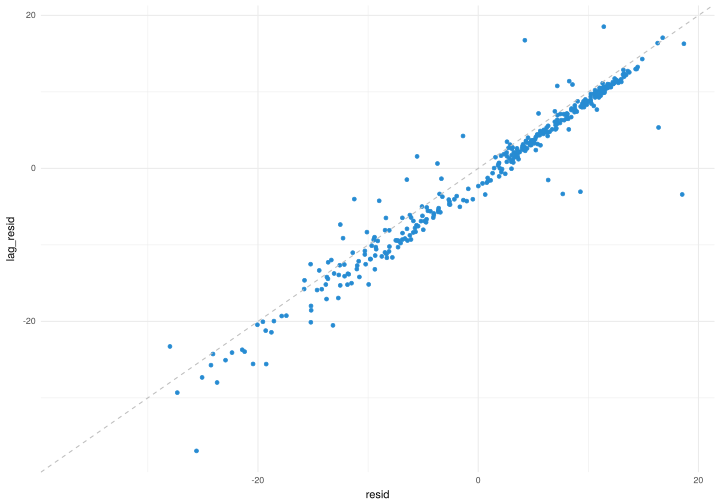

In [204]:
hiv_gap %>% add_residuals(mod) %>% group_by(country) %>% arrange(country, year) %>% 
            mutate(lag_resid = lag(resid)) %>% ggplot(aes(resid, lag_resid)) + geom_point() + 
            geom_abline(slope = 1, linetype = "dashed", colour = "grey")

The linear model assumes that the residuals are *uncorrelated*, whereas here the correlation between each residual and its lag is close to 1. There are a few ways to address this. One is to look at the first-differences model:

In [174]:
hiv_gap_2 = gapminder %>% mutate(year = make_date(year)) %>% left_join(hiv) %>% 
    arrange(country, year) %>% mutate(dlife = c(NA, diff(lifeExp)))
mod = lm(dlife ~ hiv_pct, hiv_gap_2)
mod %>% summary

Joining, by = c("country", "year")
Warning message:
“Column `country` joining factor and character vector, coercing into character vector”


Call:
lm(formula = dlife ~ hiv_pct, data = hiv_gap_2)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.4101  -0.5790  -0.1276   0.6275  12.2501 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.57571    0.09228   17.08   <2e-16 ***
hiv_pct     -0.31111    0.01869  -16.64   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.841 on 480 degrees of freedom
  (1222 observations deleted due to missingness)
Multiple R-squared:  0.3659,	Adjusted R-squared:  0.3645 
F-statistic: 276.9 on 1 and 480 DF,  p-value: < 2.2e-16


The interpretation of this regression is now different. It says that a one point increase in the HIV percentage causes the 5-year change in life expectancy to decrease by -.31 years.

If we again compare residuals, they look much more like random noise:

Warning message:
“Removed 1348 rows containing missing values (geom_point).”

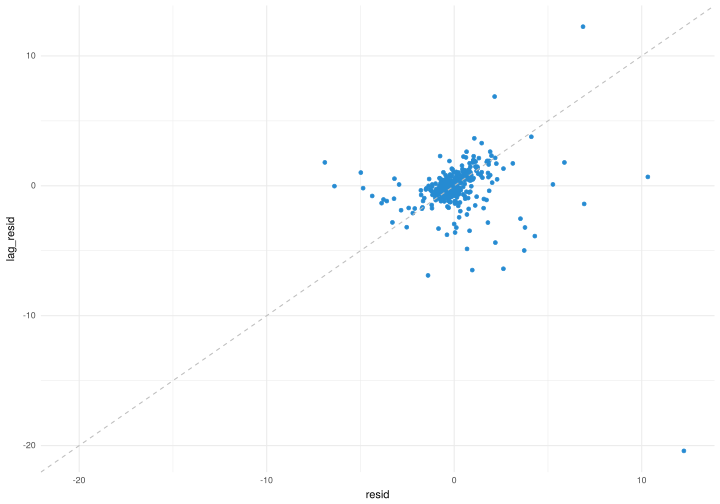

In [175]:
hiv_gap_2 %>% add_residuals(mod) %>% group_by(country) %>% arrange(country, year) %>% 
              mutate(lag_resid = lag(resid)) %>% ggplot(aes(resid, lag_resid)) + geom_point() + 
              geom_abline(slope = 1, linetype = "dashed", colour = "grey")

Since correlation in the residuals suggests an omitted variable, another option is to add more predictors to try and remove the correlation.

In [213]:
mod = lm(lifeExp ~ hiv_pct + year * continent, hiv_gap)
mod %>% summary


Call:
lm(formula = lifeExp ~ hiv_pct + year * continent, data = hiv_gap)

Residuals:
     Min       1Q   Median       3Q      Max 
-27.9653  -3.6484   0.2557   3.1888  17.1961 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             5.066e+01  2.320e+00  21.841  < 2e-16 ***
hiv_pct                -5.337e-01  7.408e-02  -7.204 2.33e-12 ***
year                    4.513e-04  2.155e-04   2.094  0.03677 *  
continentAmericas       1.339e+01  4.080e+00   3.282  0.00111 ** 
continentAsia           9.368e+00  4.420e+00   2.119  0.03458 *  
continentEurope         2.006e+01  3.545e+00   5.658 2.66e-08 ***
continentOceania        2.070e+01  1.224e+01   1.691  0.09158 .  
year:continentAmericas  2.680e-04  3.753e-04   0.714  0.47555    
year:continentAsia      3.368e-04  4.064e-04   0.829  0.40765    
year:continentEurope    7.788e-05  3.293e-04   0.236  0.81318    
year:continentOceania   2.536e-04  1.117e-03   0.227  0.82054    
---
Signif. cod

Warning message:
“Removed 1348 rows containing missing values (geom_point).”

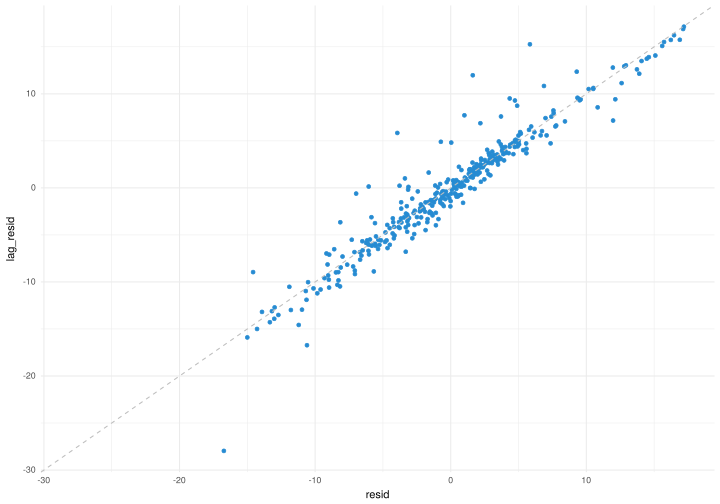

In [214]:
hiv_gap %>% add_residuals(mod) %>% group_by(country) %>% arrange(country, year) %>% 
            mutate(lag_resid = lag(resid)) %>% ggplot(aes(resid, lag_resid)) + geom_point() + 
            geom_abline(slope = 1, linetype = "dashed", colour = "grey")

Let us explore a few ways to improve this model. We might think that more than just the past year of HIV data is relevant:

In [147]:
mod = lm(dlife ~ hiv_pct + lag(hiv_pct), hiv_gap_2)
mod %>% summary


Call:
lm(formula = dlife ~ hiv_pct + lag(hiv_pct), data = hiv_gap_2)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.3703 -0.5662 -0.1323  0.5452 11.6424 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.58362    0.09160  17.289  < 2e-16 ***
hiv_pct      -0.60125    0.04297 -13.992  < 2e-16 ***
lag(hiv_pct)  0.36222    0.04839   7.486 5.72e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.558 on 353 degrees of freedom
  (1348 observations deleted due to missingness)
Multiple R-squared:  0.5237,	Adjusted R-squared:  0.521 
F-statistic: 194.1 on 2 and 353 DF,  p-value: < 2.2e-16


Looking back at the original scatter plot, we also see some countries where the HIV infection rate does not seem to substantially affect life expectancy. We suspect this is due to these countries being richer, and having a more developed public health system:

Warning message:
“Removed 1222 rows containing missing values (geom_point).”

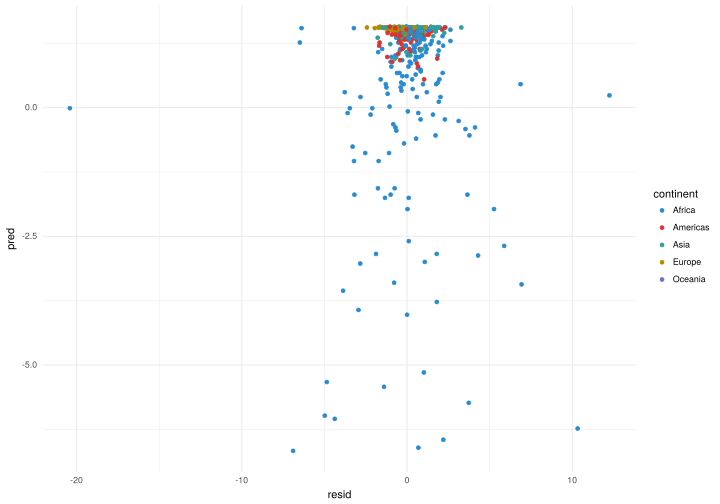

In [156]:
hiv_gap_2 %>% add_residuals(mod) %>%  add_predictions(mod) %>% 
    ggplot(aes(resid, pred, color = continent)) + geom_point()

Let us try adding an interaction term for Africa:

In [167]:
mod = lm(dlife ~ I(continent == "Africa") * hiv_pct, hiv_gap_2)
mod %>% summary


Call:
lm(formula = dlife ~ I(continent == "Africa") * hiv_pct, data = hiv_gap_2)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.6065  -0.5306  -0.0666   0.5264  12.0341 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            1.3922     0.1319  10.557   <2e-16 ***
I(continent == "Africa")TRUE           0.5041     0.2121   2.377   0.0178 *  
hiv_pct                               -0.1655     0.2314  -0.715   0.4747    
I(continent == "Africa")TRUE:hiv_pct  -0.1699     0.2323  -0.732   0.4648    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.834 on 478 degrees of freedom
  (1222 observations deleted due to missingness)
Multiple R-squared:  0.3734,	Adjusted R-squared:  0.3694 
F-statistic: 94.93 on 3 and 478 DF,  p-value: < 2.2e-16


Warning message:
“Removed 1222 rows containing missing values (geom_point).”

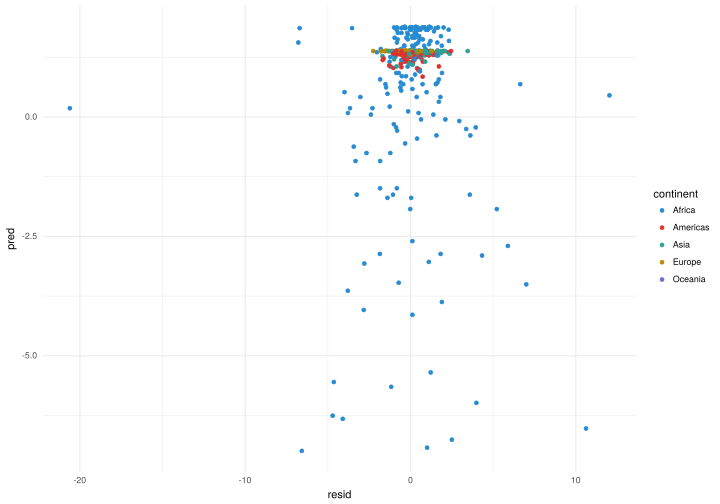

In [160]:
hiv_gap_2 %>% add_residuals(mod) %>%  add_predictions(mod) %>% 
              ggplot(aes(resid, pred, color = continent)) + geom_point()

In [171]:
mod = lm(dlife ~ gdpPercap * hiv_pct, hiv_gap_2)
mod %>% summary


Call:
lm(formula = dlife ~ gdpPercap * hiv_pct, data = hiv_gap_2)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.4645  -0.5281   0.0214   0.4935  12.1539 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1.936e+00  1.265e-01  15.302  < 2e-16 ***
gdpPercap         -3.281e-05  8.057e-06  -4.072 5.45e-05 ***
hiv_pct           -3.748e-01  2.620e-02 -14.307  < 2e-16 ***
gdpPercap:hiv_pct  1.151e-05  4.415e-06   2.606  0.00944 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.809 on 478 degrees of freedom
  (1222 observations deleted due to missingness)
Multiple R-squared:  0.3902,	Adjusted R-squared:  0.3864 
F-statistic:   102 on 3 and 478 DF,  p-value: < 2.2e-16


Warning message:
“Removed 1222 rows containing missing values (geom_point).”

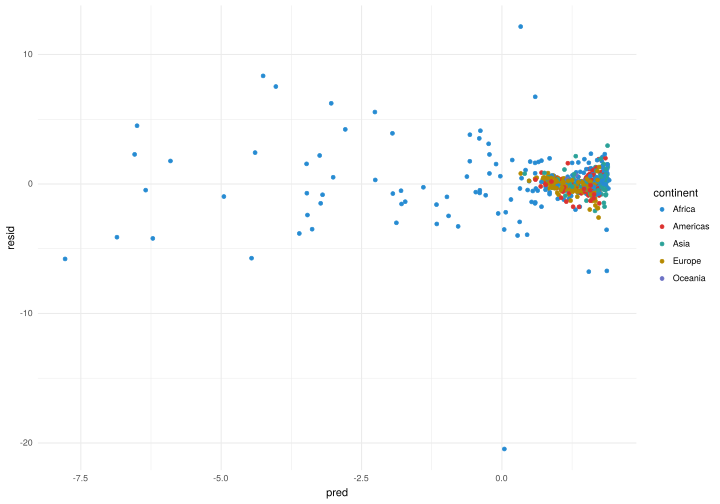

In [173]:
hiv_gap_2 %>% add_residuals(mod) %>%  add_predictions(mod) %>% 
              ggplot(aes(pred, resid, color = continent)) + geom_point()

One thing that is obvious in these plots is that the error variance is different for different continents:

Warning message:
“Removed 1222 rows containing non-finite values (stat_boxplot).”

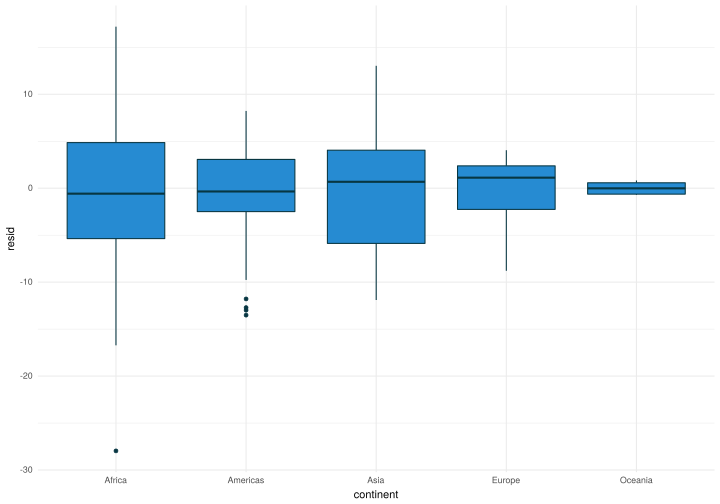

In [215]:
hiv_gap_2 %>% add_residuals(mod) %>% ggplot(aes(continent, resid)) + geom_boxplot()

Another option for dealing with autocorrelated data is to explicitly model the autocorrelation. 

In [293]:
library(nlme)
head(hiv_gap_2)
mod = gls(lifeExp ~ I(continent == "Africa") * hiv_pct * gdpPercap, data = hiv_gap_2, 
          na.action = na.omit, 
          correlation = corAR1())
summary(mod)


  country     continent year       lifeExp pop      gdpPercap hiv_pct dlife
1 Afghanistan Asia      1952-01-01 28.801   8425333 779.4453  NA         NA
2 Afghanistan Asia      1957-01-01 30.332   9240934 820.8530  NA      1.531
3 Afghanistan Asia      1962-01-01 31.997  10267083 853.1007  NA      1.665
4 Afghanistan Asia      1967-01-01 34.020  11537966 836.1971  NA      2.023
5 Afghanistan Asia      1972-01-01 36.088  13079460 739.9811  NA      2.068
6 Afghanistan Asia      1977-01-01 38.438  14880372 786.1134  NA      2.350

Generalized least squares fit by REML
  Model: lifeExp ~ I(continent == "Africa") * hiv_pct * gdpPercap 
  Data: hiv_gap_2 
       AIC      BIC    logLik
  2792.876 2834.488 -1386.438

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.6487573 

Coefficients:
                                                   Value Std.Error   t-value
(Intercept)                                     66.70822 0.8248988  80.86837
I(continent == "Africa")TRUE                   -14.96181 0.9809491 -15.25239
hiv_pct                                         -1.24493 1.1346017  -1.09724
gdpPercap                                        0.00043 0.0000418  10.38811
I(continent == "Africa")TRUE:hiv_pct             0.83670 1.1401359   0.73386
I(continent == "Africa")TRUE:gdpPercap           0.00120 0.0001835   6.53477
hiv_pct:gdpPercap                                0.00001 0.0001235   0.11367
I(continent == "Africa")TRUE:hiv_pct:gdpPercap  -0.00006 0.0001250  -0.51332
                  

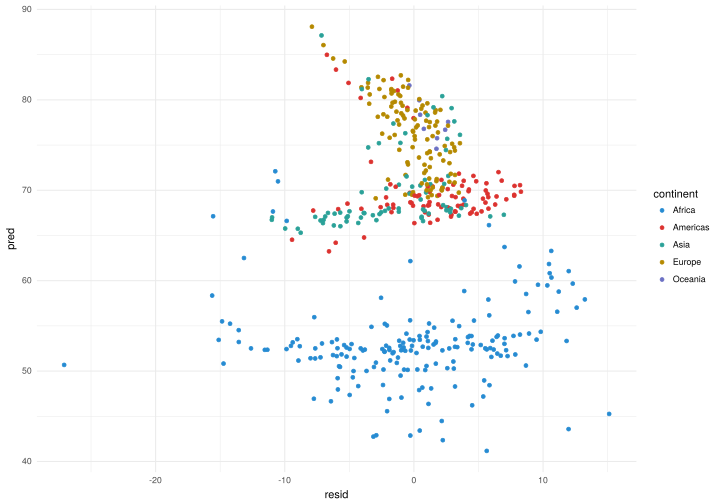

In [294]:
hiv_gap_2 %>% na.omit %>% add_residuals(mod) %>% add_predictions(mod) %>% 
              ggplot(aes(resid, pred, color = continent)) + geom_point() +
              geom_abline(slope=1)